# Tutorial

In this document, we'll show how to use this package, and compare the results to a frequentist, ad-hoc method of estimating the diffusion coefficient and its uncertainty.

In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion
from Bayesian_Particle_Tracking.data_analysis import max_likelihood_estimation
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.printable import Printable
from Bayesian_Particle_Tracking import generate_data
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


We will use generated data so that it will be convenient for evaluating the validity of our method, since we will know the diffusion coefficient.  $\sigma=10^{-6}$m and $D = 10^{-10}m^2/s$, where $\sigma$ is the measurement uncertainty on the particle's position. Our starting position is at the origin. We will look at a single particle over 100000 time frames of 1 second each. (Note that tau in the generator function is a keyword argument with its default set to 1.)

In [2]:
#Generated the data with the following code.
#data = Bayesian_Particle_Tracking.generate_data.generator(100000,1e-6,1e-10,[0,0,0], parameter = "D")
#np.save('compare_data', data)

home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/"
data = np.load(home_dir + 'compare_data.npy')
compare_input = diffusion(data)


To evaluate the diffusion coefficient we will be using Markov Chain Monte Carlo with the emcee package.

In [3]:
#the model has 1 parameter; we'll use 40 walkers and 500 steps
ndim = 1
nwalkers = 16
nsteps = 500

starting_positions = [abs(10**(-10) + 1e-10*np.random.randn(ndim)) for i in range(nwalkers)]

#starting_positions = emcee.utils.sample_ball(
#    ([10**(-10)]),
#    ([10**(-10)]),nwalkers)

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[compare_input])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 56.9 s, sys: 3.05 s, total: 60 s
Wall time: 1min 1s
Done


Plotting our walkers:

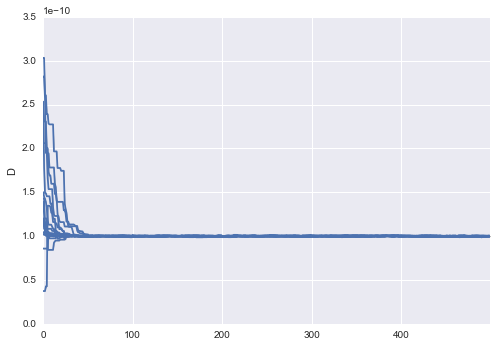

In [4]:
fig, (ax_D) = plt.subplots(1)
ax_D.set(ylabel='D')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_D)

This is a pretty fast burn in time. We'll cut out the first 75 steps.

In [5]:
samples = sampler.chain[:,75:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'D': traces[0]})

Now let's plot the marginal pdf of D:

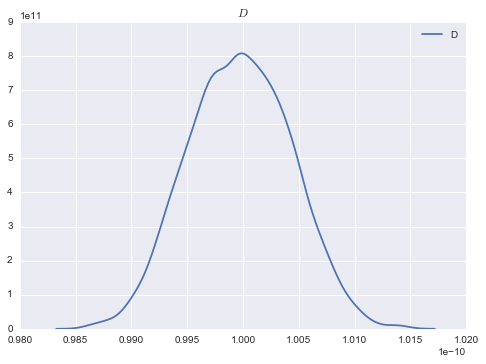

In [6]:
sns.kdeplot(parameter_samples['D'])
plt.title('$D$')

In [7]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("D = {:.4e} + {:.4e} - {:.4e}".format(q['D'][0.50], 
                                            q['D'][0.84]-q['D'][0.50],
                                            q['D'][0.50]-q['D'][0.16]))

D = 9.9970e-11 + 4.7370e-13 - 4.6770e-13


This is very close to what we expect, and the true value of D is well contained within our 68% credibility interval.

## Maximum Likelihood Estimation

In [70]:
%time D, Dbest, loglikelihood, Dmin, Dmax = max_likelihood_estimation(compare_input, -11, -9, 10000)

CPU times: user 1min 8s, sys: 964 ms, total: 1min 9s
Wall time: 1min 12s


In [71]:
print("D = {:.4e} + {:.4e} - {:.4e}".format(Dbest, 
                                            Dmax-Dbest,
                                            Dbest-Dmin))

D = 1.0002e-10 + 4.1546e-13 - 4.1374e-13


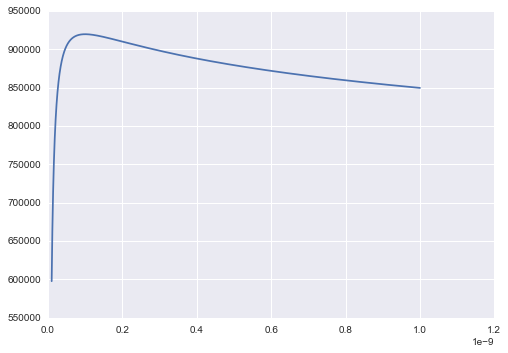

In [72]:
plt.plot(D, loglikelihood)

## Ad Hoc Method

This method is taken from Jerome Fung's 2013 doctoral dissertation at Harvard University, _Measuring the 3D Dynamics of Multiple Colloidal Particles_. The method, described as a "Flyvbjerg-Peterson (FB) algorithm" is described as follows:

1. Begin with correlated data (i.e., a set of squared displacements) $x_i$
2. Block-decorrelate the data (with Flybjerg-Peterson block-decorrelation). At each block decorrelation step, calculate var($x'_i$)/(N'-1)
3. To find the leftmost fixed-point region (smallest number of decorrelation setps), check if the variance estimate after $j$ transformations lies within the 1-sigma error bars of the variance estimate after j+1 transformations. The leftmost point to be considered fixed is the first point satisfying this criterior.
4. Repeat Step 3 from the right to find the rightmost edge of the fixed point region.
5. Compute a weighted average of all the var($x'_i$)/(N'-1) in the fixed-point region, where the weights by the 1-sigma error bars.

First we define our squared displacement function.

We'll also define a function to calculate MSD for illustrative purposes

In [74]:
def sq_displacement(data):
    data_length = len(data)
    point_before = data[:len(data)-1]
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]

    data_points = data[1:]
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)
    return distance**2

def MSD(data):
    return np.sum(sq_displacement(data))/len(data)

Below we see the results for distributions of MSDs obtained from 1000 simulated experiments in which N=1000 displacements are sampled (to generate this data the displacement array for a particle that took 1,000,000 steps  was split into 1000 arrays). The value of D is chosen with D = $10^{-10} m^2/s$ and $\tau = 1$s such that the true value of the MSD should be 

$$\langle\Delta x^2 \rangle = 6*D*\tau = 6*10^{-10}m^2$$

9.86826583866e-11


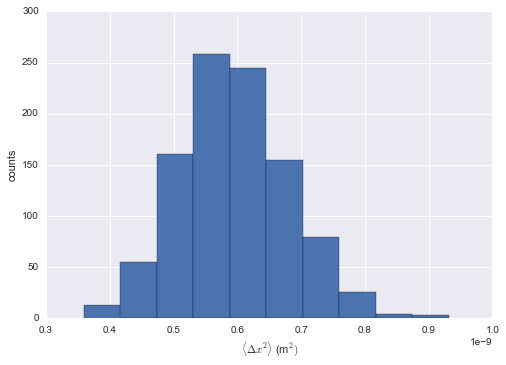

In [75]:
test_data = np.split(data,1000)
msd_array = np.array(list(map(MSD,test_data)))
plt.hist(msd_array)
print(np.median(msd_array)/6)
plt.ylabel('counts')
plt.xlabel('$\langle \Delta x^2 \\rangle$ (m$^2)$')

The standard error of the of sample variance goes as 1/$\sqrt{N}$, but to calculate the true standard error on the sample variance we use the FP algorithm.

# TODO:

Verify that the calculations for the variance of the mean and that uncertainty on the variance is correct.

In [10]:
msd_array = sq_displacement(data)
new_length = len(msd_array)

output_var = []
var_uncertainty = []

for i in range(0,8):
    #length of the next array should be 2 times smalller (2^(i+1) times smaller overall)
    new_length = len(msd_array)/2
    new_array = np.zeros(new_length)
    #iterate over each element of the new array
    for i in range(0,len(new_array)):
        #Each element is given by the average of the corresponding 2 elements in the previous array
        new_array[i] = (msd_array[2*i-1]+msd_array[2*i])/2
    output_var.append(np.var(new_array)/(len(new_array)-1))
    var_uncertainty.append(np.var(new_array)/(len(new_array)-1)*np.sqrt(2/(len(new_array)-1)))
    msd_array = new_array

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


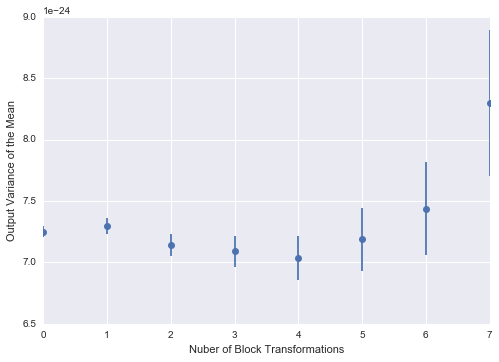

In [11]:
b = np.arange(0,len(output_var))
plt.errorbar(b,output_var, yerr = var_uncertainty, fmt='o')
plt.ylabel('Output Variance of the Mean')
plt.xlabel('Nuber of Block Transformations')

We can see that from the FP method, we should take the average of points 3 through 5 to find the variance on the sample mean.

In [12]:
print(np.sqrt(np.mean(output_var[2:7])))

2.67923469954e-12


We see that from the FP method we obtain a 68% confidence interval (1-sigma) of $\pm 2.68*10^{-12}$

Compare this to the 68% credibility interval by MCMC of $~ \pm 4*10^{-13}$

## CGW Method

This method is alluded to in Jerome Fung's Thesis, and is one of the primary ways of estimating the diffusion coefficient in colloid physics. The idea is to take a set of MSDs and then fit a line of the form nD$\tau$ to the plot of MSD as a function of lag time where n is the number of dimensions. The relative standard error of the variance, $\sigma_{var}/var$ can be computed by:

$$\frac{\sigma_{var}}{var}=\sqrt{\frac{2}{N_{ind}-1}}$$

where $N_{ind}$ is the number of independent displacements. In the CGW method, this is given by:

$$N_{ind, CGW} = 2\frac{N-n}{n}$$

where n is the number of time steps between displacements for a trajectory of N timesteps.

In [13]:
def MSD(data, i):
    """
    Returns MSD for i arbitrary time steps
    """
    data_length = len(data)
    point_before = data[:data_length-i]
    point_after = data[i:]
    
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]
    x_after, y_after, z_after = point_after[:,0], point_after[:,1], point_after[:,2]
    SD = (x_before-x_after)**2+(y_before-y_after)**2+(z_before-z_after)**2
    return np.mean(SD)

def Nind(data, i):
    N = len(data)
    return 2*(N - i)/i
    
def sigma_var(data, i):
    return MSD(data, i)*np.sqrt(2/(Nind(data, i)-1))

def CGW_analysis(diffusion_object, max_lag_time, down_sample = 10):
    """
    Crocker, Grier, Weeks
    """
    msd_array = []
    sigma_var_array = []
    counter = np.arange(1,max_lag_time,down_sample)
    
    for i in range(1, max_lag_time, down_sample):
        msd_array.append(MSD(diffusion_object.data, i))
        sigma_var_array.append(sigma_var(diffusion_object.data, i))
        
    msd_array = np.array(msd_array)
    sigma_var_array = np.array(sigma_var_array)
    return msd_array, sigma_var_array, counter

In [59]:
msd, sigma, counter = CGW_analysis(compare_input, 20000, down_sample = 10)

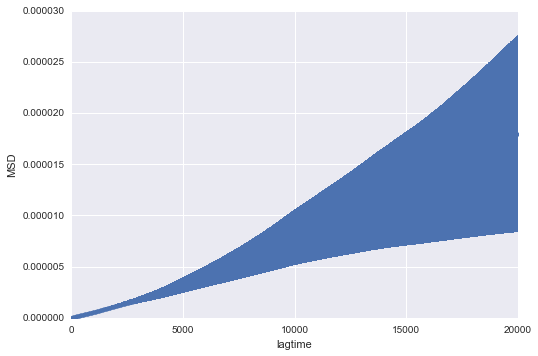

In [60]:
plt.errorbar(counter, msd, yerr = sigma, fmt = '.')
plt.xlabel('lagtime')
plt.ylabel('MSD')

In [61]:
from scipy.optimize import curve_fit

In [62]:
def f(tau,D):
    return 6*D*tau

In [63]:
popt, pcov = curve_fit(f, counter, msd, sigma = sigma)
D = popt[0]
sigma_D = np.sqrt(pcov[0])
sigma_D

array([  1.39960420e-13])

In [64]:
print("D = %.4e + %.4e - %.4e" %(D, sigma_D, sigma_D))

D = 9.9905e-11 + 1.3996e-13 - 1.3996e-13


Pretty good, but not as accurate as MCMC or MLE.

In [40]:
msdbad, sigmabad, counterbad = CGW_analysis(compare_input, 50000, down_sample = 10)

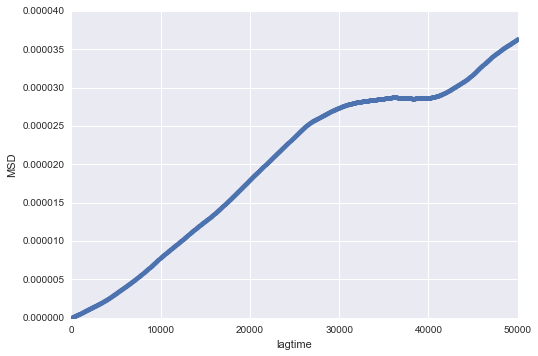

In [41]:
plt.errorbar(counterbad, msdbad, yerr = 0, fmt = '.')
plt.xlabel('lagtime')
plt.ylabel('MSD')

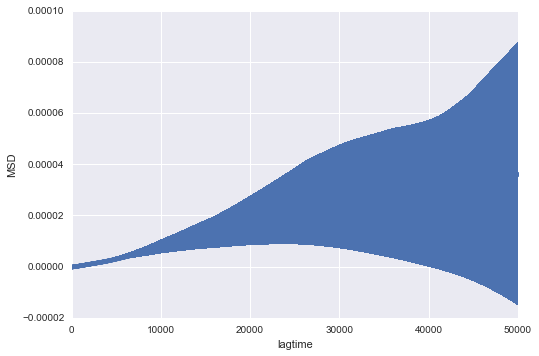

In [42]:
plt.errorbar(counterbad, msdbad, yerr = sigmabad, fmt = '.')
plt.xlabel('lagtime')
plt.ylabel('MSD')

In [43]:
popt, pcov = curve_fit(f, counterbad, msdbad, sigma = sigmabad)
Dbad = popt[0]
sigma_Dbad = np.sqrt(pcov[0])
sigma_Dbad

array([  1.12430000e-13])

In [44]:
print("D = %.4e + %.4e - %.4e" %(Dbad, sigma_Dbad, sigma_Dbad))

D = 1.0044e-10 + 1.1243e-13 - 1.1243e-13


## Actual Data

Now lets do some analysis on actual data. Data provided by Viva Horowitz.

In [2]:
home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/"
trajectory_dataframe = pd.read_pickle('/Users/alanzhou/Documents/Physics_201/final_project/160408,_e_coli_and_tracers_in_droplets_viva_pickled,_tracked_by_ZCC,_filtered_data_with_drift_subtracted_pickled.pkl')

In [3]:
framerate = 1/11.999
magnification = 0.12690355329e-6
relevant = trajectory_dataframe[['frame', 'ep', 'particle', 'x', 'y']]
relevant

,frame,ep,particle,x,y
frame,,,,,
0,0.0,0.048181,1.0,549.336236,143.804503
0,0.0,0.041715,4.0,372.135563,168.389727
0,0.0,0.051584,5.0,516.364185,169.557935
0,0.0,0.052604,6.0,476.871945,171.904461
0,0.0,0.051734,8.0,579.902433,175.419332
0,0.0,0.046582,18.0,362.085964,252.677716
0,0.0,0.042600,22.0,388.877641,279.323083
0,0.0,0.062479,28.0,701.583660,330.457355
0,0.0,0.076062,29.0,276.993789,330.646458


In [4]:
def single_vector(dataframe, max_counts):
    lastrow = [0,0,0,0]
    single = []
    for i in range (0, max_counts):
        if dataframe[dataframe['particle'] == i].empty == False:
            frame = np.array(dataframe[dataframe['particle'] == i][['x','y', 'ep', 'frame']])
            firstrow = [frame[0,0], frame[0,1], frame[0,2], frame[0,3]]
            new_frame = frame - firstrow + lastrow 
            length = len(frame)-1
            lastrow = [new_frame[length,0], new_frame[length,1], new_frame[length,2], new_frame[length,3]]
            single += list(new_frame)
    return np.array(single)

In [5]:
particle_max = 14000
%time single = single_vector(relevant, particle_max)
single[:,0] *= magnification
single[:,1] *= magnification
single[:,2] *= magnification
single[:,3] *= framerate


CPU times: user 12.5 s, sys: 242 ms, total: 12.8 s
Wall time: 13 s


Unfortunately, our likelihood function right now only accepts time displacement as input rather than absolute time. TODO: change so that input is absolute time.

In [6]:
timedifference = list(np.diff(single[:,3]))
timedifference.insert(0,0)

In [7]:
new_single = np.copy(single)
new_single[:,3] = timedifference

In [8]:
single_diffusion = diffusion(new_single)
single_diffusion.dim

2

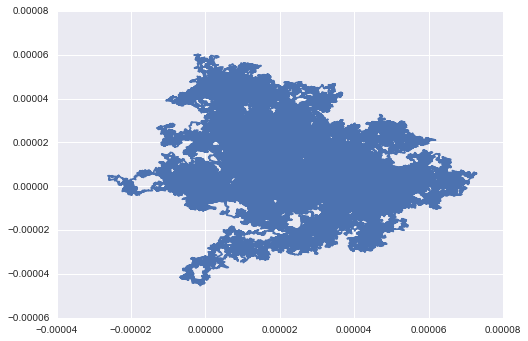

In [9]:
plt.plot(single_diffusion.x, single_diffusion.y)

In [105]:
%time D, Dbest, loglikelihood, Dmin, Dmax = max_likelihood_estimation(single_diffusion, -14, -12, 10000)

CPU times: user 4min 14s, sys: 1min 16s, total: 5min 31s
Wall time: 13min 9s


In [109]:
print("Maximum Likelihood Estimation: D = {:.3e} + {:.3e} - {:.3e}".format(Dbest, 
                                            Dmax-Dbest,
                                            Dbest-Dmin))

Maximum Likelihood Estimation: D = 3.892e-13 + 1.077e-15 - 1.074e-15


Now for a more Bayesian approach. We'll do MCMC.

In [15]:
#the model has 1 parameter; we'll use 40 walkers and 500 steps
ndim = 1
nwalkers = 10
nsteps = 500

starting_positions = [abs(1e-13 + 1e-13*np.random.randn(ndim)) for i in range(nwalkers)]

#starting_positions = emcee.utils.sample_ball(
#    ([10**(-10)]),
#    ([10**(-10)]),nwalkers)

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[single_diffusion],
                                kwargs = {'lower_bound': 1e-14, 'upper_bound': 1e-12})
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 2min 19s, sys: 53.3 s, total: 3min 12s
Wall time: 3min 19s
Done


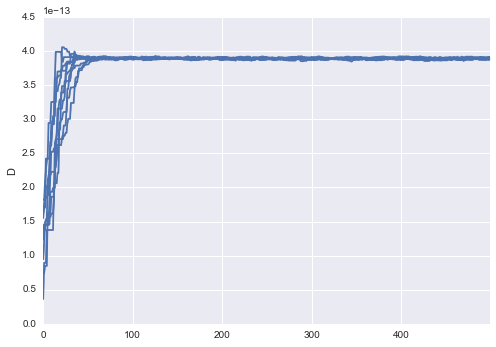

In [16]:
fig, (ax_D) = plt.subplots(1)
ax_D.set(ylabel='D')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_D)

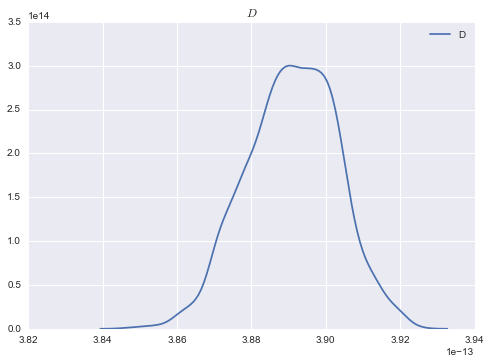

In [18]:
samples = sampler.chain[:,75:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'D': traces[0]})
sns.kdeplot(parameter_samples['D'])
plt.title('$D$')

In [19]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("D = {:.4e} + {:.4e} - {:.4e}".format(q['D'][0.50], 
                                            q['D'][0.84]-q['D'][0.50],
                                            q['D'][0.50]-q['D'][0.16]))

D = 3.8913e-13 + 1.1659e-15 - 1.3084e-15
